In [2]:
import os

# Afficher le répertoire courant
#print(os.getcwd())

# Mettre dossier de base
os.chdir("..\Données")

print(os.getcwd())  # Vérifie


c:\Users\nguye\Desktop\Enzo\Cours\M1 MIASHS\TER - Redshift\Données


Objectif
--------
Créer un modèle de régression linéaire (baseline OLS + Ridge) pour prédire le redshift ZSPEC
à partir des magnitudes (u, g, r, i, z, y, …). Le code :
1) charge ton .npz,
2) extrait les colonnes utiles,
3) gère les valeurs manquantes (-99, etc.),
4) crée des couleurs (différences de magnitudes),
5) split train/test, standardise,
6) entraîne OLS et Ridge,
7) évalue (MAE, RMSE, R²) et trace Vrai vs Prédit.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

0) Paramètres / fichier


In [7]:
npz_path = "XMM_LSS_v11_uijk_0006_spec_D.npz"  # adapte le chemin si besoin
bands_all = ["u","g","r","i","z","y","J","H","K"]  # ordre logique des bandes

1) Charger les données

In [8]:
data = np.load(npz_path, allow_pickle=True)
info = data["info"]  # tableau structuré (dtype avec champs nommés)

# Vérifier quelles bandes et la cible existent réellement
mag_cols = [b for b in bands_all if b in info.dtype.names]
target_col = "ZSPEC"
if target_col not in info.dtype.names:
    raise RuntimeError("La cible ZSPEC n'est pas présente dans info.")

2) Construire un DataFrame

In [9]:
df = pd.DataFrame({c: info[c].astype(float) for c in mag_cols})
df["ZSPEC"] = info[target_col].astype(float)

3) Nettoyage des valeurs manquantes

In [12]:
# Les valeurs sentinelles (-99, etc.) signifient “pas de mesure”.
sentinels = [-99.0, -99.108, -999.0, 99.0]
df = df.replace(sentinels, np.nan)

# Supprimer les bandes TROP manquantes (ex: on garde les colonnes avec >= 5 valeurs valides)
min_valid = 5 if len(df) >= 8 else max(3, int(len(df)*0.6))
keep_mag = [c for c in mag_cols if df[c].notna().sum() >= min_valid]
df = df[keep_mag + ["ZSPEC"]]

4) Créer des couleurs

In [13]:
# Les couleurs (différences) capturent mieux la forme du SED que les magnitudes absolues.
ordered = [b for b in bands_all if b in keep_mag]
for a, b in zip(ordered, ordered[1:]):
    df[f"{a}-{b}"] = df[a] - df[b]

5) Features / Cible

In [14]:
X_cols = [c for c in df.columns if c != "ZSPEC"]
X = df[X_cols].values
y = df["ZSPEC"].values

# Imputation des NaN restants (médiane par colonne)
X = SimpleImputer(strategy="median").fit_transform(X)

6) Split + standardisation

In [15]:
# Jeu minuscule -> test_size un peu plus grand pour garder au moins 2 points de test
test_size = 0.25 if len(df) >= 8 else 0.33 if len(df) >= 3 else 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

7) Modèles : OLS + Ridge

In [ ]:
ols   = LinearRegression().fit(X_train_s, y_train) # OLS = Ordinary Least Squares = régression linéaire classique
ridge = Ridge(alpha=1.0, random_state=42).fit(X_train_s, y_train) # Ridge = régression linéaire avec régularisation L2

def report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred) # Mean Absolute Error = Erreur Absolue Moyenne
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Root Mean Squared Error = Erreur Quadratique Moyenne
    r2   = r2_score(y_true, y_pred) # Coefficient de détermination R^2 = proportion de variance expliquée
    print(f"{name:>8s} | MAE={mae:.4f} | RMSE={rmse:.4f} | R^2={r2:.4f}")
    return mae, rmse, r2

print("Colonnes magnitudes conservées:", keep_mag)
print("Features utilisées:", X_cols)
print("Taille finale:", df.shape, "\n")

print("==> Performances sur test :")
y_pred_ols = ols.predict(X_test_s)
y_pred_rdg = ridge.predict(X_test_s)
report("OLS",   y_test, y_pred_ols)
report("Ridge", y_test, y_pred_rdg)

Colonnes magnitudes conservées: ['u', 'g', 'r', 'i', 'z', 'y']
Features utilisées: ['u', 'g', 'r', 'i', 'z', 'y', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y']
Taille finale: (8, 12) 

==> Performances sur test :
     OLS | MAE=10.9690 | RMSE=14.7859 | R^2=-2962.1774
   Ridge | MAE=2.5002 | RMSE=3.3922 | R^2=-154.9620


(2.5002139841035427, np.float64(3.3921825112811503), -154.96204742100815)

8) Visualisation

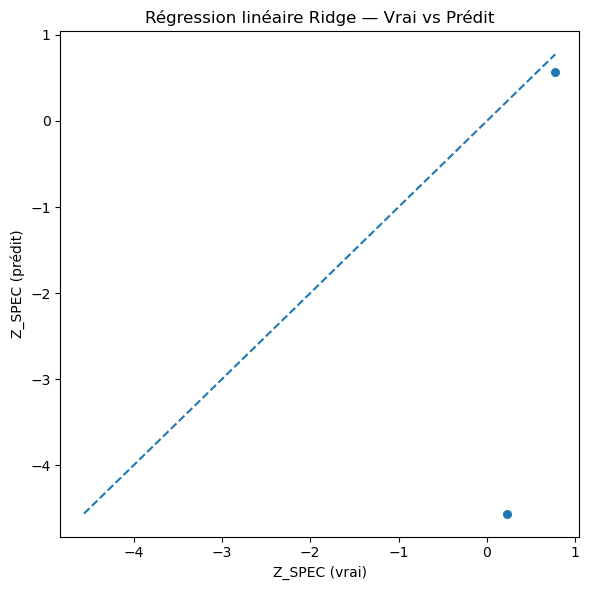

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rdg, s=30)         # points prédits
mn = float(min(y_test.min(), y_pred_rdg.min()))
mx = float(max(y_test.max(), y_pred_rdg.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")  # diagonale “parfaite”
plt.xlabel("Z_SPEC (vrai)")
plt.ylabel("Z_SPEC (prédit)")
plt.title("Régression linéaire Ridge — Vrai vs Prédit")
plt.tight_layout()
plt.show()

9) Interprétation simple

In [20]:
coef_table = pd.DataFrame({
    "feature": X_cols,
    "coef_OLS": ols.coef_,
    "coef_Ridge": ridge.coef_
}).sort_values("coef_Ridge", key=lambda s: s.abs(), ascending=False)
print("\nCoefficients (triés par |coef_Ridge|) :")
print(coef_table.to_string(index=False))


Coefficients (triés par |coef_Ridge|) :
feature   coef_OLS  coef_Ridge
      r   7.858662    0.143249
      y  -8.553443    0.131947
      u   2.832755    0.108104
      i  -1.929446    0.093236
      z   0.599665    0.083402
    r-i   2.650454   -0.064908
    z-y   1.874681    0.058272
      g  -6.205479    0.045449
    u-g -16.815553   -0.044731
    i-z  -2.507649    0.023516
    g-r  -6.762011    0.019447
